### Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [2]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the HSC-SSP AGN table:

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [4]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
data_agn

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015
--,deg,deg,mag,--,--,--,--,--,--,--,--,--
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508


1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

### Match to SIMBAD

Field description refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [20]:
mask_specz = data_agn['r_z'] < 3

print(len(data_agn[mask_specz]))

from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 
result_table

337
310


/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,RVZ_QUAL,RVZ_WAVELENGTH,Z_VALUE,RVZ_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,str1,str1,float64,object,int32
COSMOS2015 594392,10 02 58.52,+02 12 08.9,6,6,--,--,0,C,O,2007ApJS..172...99C,E,,1.7643000,2013ApJS..206....8M,1
SDSS J100256.53+021158.4,10 02 56.5328,+02 11 58.411,14,14,1.883,1.219,90,A,O,2020yCat.1350....0G,C,O,3.5026000,2014A&A...563A..54P,2
SDSS J100256.04+020923.2,10 02 56.045,+02 09 23.22,7,7,68.000,63.000,0,C,O,2009ApJS..182..543A,D,O,0.9790000,2009ApJ...696.1195T,3
COSMOS2015 552225,10 03 11.27,+02 08 20.1,6,6,--,--,0,C,O,2007ApJS..172...99C,D,O,0.5727000,2018A&A...611A..53J,4
SDSS J100307.82+021134.9,10 03 07.825,+02 11 34.98,7,7,78.000,76.000,0,C,O,2009ApJS..182..543A,C,O,0.5824000,2009ApJ...696.1195T,5
SDSS J100252.84+021452.8,10 02 52.841,+02 14 52.80,7,7,76.000,62.000,0,C,O,2009ApJS..182..543A,C,O,0.6652000,2009ApJ...696.1195T,6
[VV2006] J100309.2+022038,10 03 09.2100,+02 20 38.330,14,14,0.523,0.504,90,A,O,2020yCat.1350....0G,D,O,1.9555000,2009ApJ...696.1195T,7
[VV2006] J100251.7+022905,10 02 51.6243,+02 29 05.367,14,14,0.291,0.298,90,A,O,2020yCat.1350....0G,D,O,2.0051000,2009ApJ...696.1195T,8


In [6]:
len(result_table['SCRIPT_NUMBER_ID'])

498

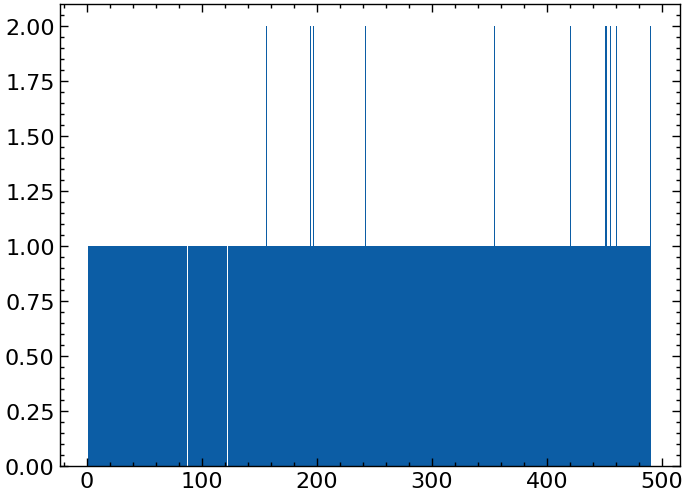

In [88]:
# check if almost each item has a return

plt.hist(result_table['SCRIPT_NUMBER_ID'], bins=490);

In [14]:
unq, unq_idx, unq_cnt = np.unique(result_table['SCRIPT_NUMBER_ID'], return_inverse=True, return_counts=True)

# result_table['SCRIPT_NUMBER_ID'] #[unq_cnt>1]

In [8]:
len(unq_cnt)

489

### Add the new SIMBAD spec-z back into the table

0 = SIMBAD spec-z

In [89]:
idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['bibcode'] = '-'*19
# refers to teh note in 'hsc_agn.txt': 
data_agn_updated['bibcode'][data_agn['r_z']==1] = '2020ApJ...894...24K'
data_agn_updated['bibcode'][data_agn['r_z']==2] = '2018ApJ...858...77H'

#for i in idx_simbad_specz:
for j,i in enumerate(idx_simbad_specz):
    # Update if no existing spec-z
    if data_agn_updated['r_z'][i] > 2:
        data_agn_updated['r_z'][i] = 0
        #data_agn_updated['r_z'][i] = result_table['Z_VALUE'][i]
        data_agn_updated['z'][i] = result_table['Z_VALUE'][j]
        data_agn_updated['bibcode'][i] = result_table['RVZ_BIBCODE'][j]
    # Check for inconsistent spec-z's...

mask_specz_updated = data_agn_updated['r_z'] < 3
print(len(data_agn_updated[mask_specz_updated]))
mask_specz = data_agn['r_z'] < 3
print(len(data_agn[mask_specz]))

data_agn_updated.write('hsc_agn_updated.txt', format='ascii', overwrite=True)

392
337


In [82]:
sum(data_agn_updated['r_z']==2)

21

In [90]:
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508,2020ApJ...894...24K


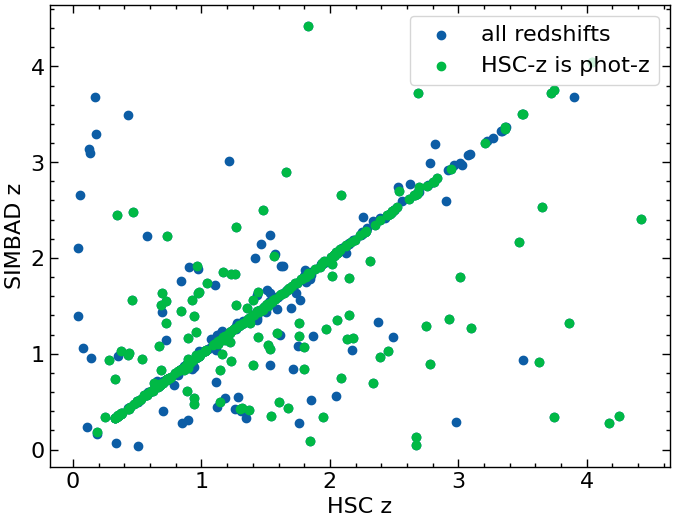

In [19]:
plt.scatter(result_table['Z_VALUE'], data_agn_updated['z'][idx], label='all redshifts')#, c=result_table['SCRIPT_NUMBER_ID'])
plt.scatter(result_table['Z_VALUE'][mask_spec_simbad], data_agn_updated['z'][idx][mask_spec_simbad], label='HSC-z is phot-z')
plt.xlabel('HSC z')
plt.ylabel('SIMBAD z')
plt.legend(frameon=True)

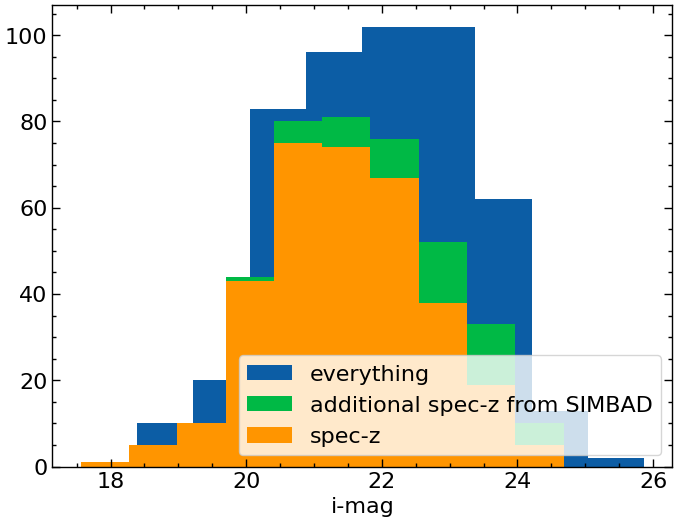

In [11]:
mask_specz_updated = data_agn_updated['r_z'] < 3
plt.hist(data_agn_updated['i-mag'], label='everything')
plt.hist(data_agn_updated['i-mag'][mask_specz_updated], label='additional spec-z from SIMBAD')
mask_specz = data_agn['r_z'] < 3
plt.hist(data_agn['i-mag'][mask_specz], label='spec-z')
plt.xlabel('i-mag')
plt.legend(frameon=True, loc=4)

### Manually inspect the inconsistent spec-zs

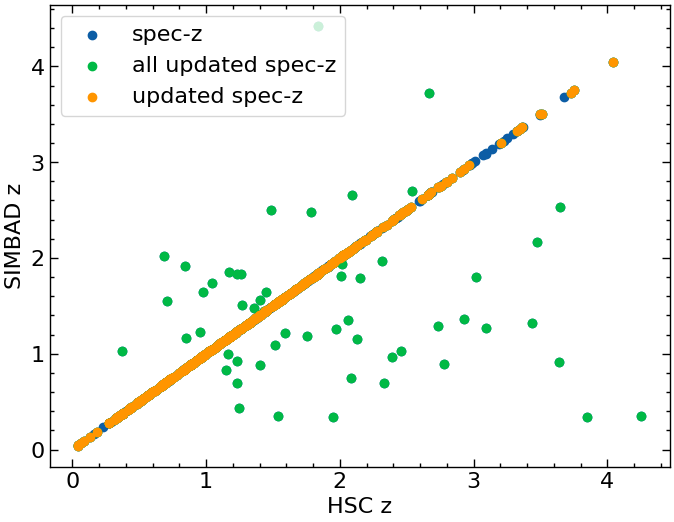

In [12]:
plt.scatter(data_agn['z'], data_agn_updated['z'], label='spec-z')
plt.scatter(data_agn['z'][mask_specz_updated], data_agn_updated['z'][mask_specz_updated], label='all updated spec-z')
plt.scatter(data_agn['z'][mask_specz & mask_specz_updated], data_agn_updated['z'][mask_specz & mask_specz_updated], label='updated spec-z')
plt.xlabel('HSC z')
plt.ylabel('SIMBAD z')
plt.legend(frameon=True)

### Make a table of where spectra come from 

In [91]:
# numher of spectra eventually using simbad, not used
id_simbad = data_agn_updated[data_agn_updated['r_z']==0]['ID']
len(id_simbad)
# mask_simbad_specz_simbad = np.isin(result_table['SCRIPT_NUMBER_ID'], id_simbad)

55

"`-------------------`" means photo-z

`2020ApJ...894...24K` and `2018ApJ...858...77H` refers to original catalogs

In [99]:
result_rvz_bib = data_agn_updated['bibcode']
bib, cnt = np.unique(result_rvz_bib, return_counts=True)
table.Table([bib, cnt], names=['bibcode', 'count'])

bibcode,count
str19,int64
-------------------,99
2007ApJS..172...70L,3
2007ApJS..172...99C,1
2009ApJ...696.1195T,36
2010AJ....140..533G,1
2011ApJ...742...61S,1
2012MNRAS.427.3103B,3
2014A&A...563A..54P,1
2015A&A...584A..62C,1


### Download the spectra

In [13]:
# Charlotte has already done SDSS - nice!

# Will add the other ones (XMM-spec, Caltech COSMOS Magellen etc,)